In [129]:
import pickle 
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from utils import get_all_atom_types, clean_dataset

## 1. Loading data

In [130]:
training_data_path = 'data/training_data.pkl'
test_data_path = 'data/test_data.pkl'
training_labels_path = 'data/training_labels.pkl'

In [131]:
with open(training_data_path, 'rb') as f :
    training_data = pickle.load(f)

with open(training_labels_path, 'rb') as f :
    training_labels = pickle.load(f)

with open(test_data_path, 'rb') as f :
    test_data = pickle.load(f)

## 2. Display molecules

In this section, we show two useful ways to display molecules.

In [132]:
# Get brief overview on the first molecule
print(training_data[0])

Graph with 16 nodes and 16 edges


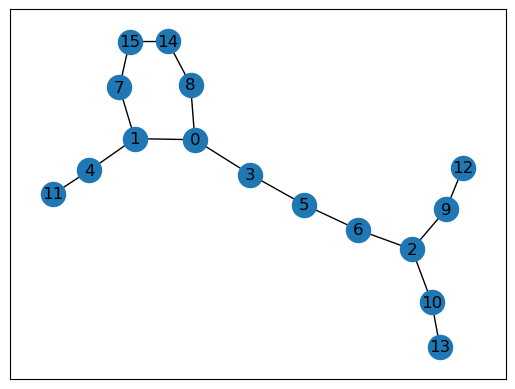

In [133]:
# Display first molecule with nodes ids.
nx.draw_networkx(training_data[0])

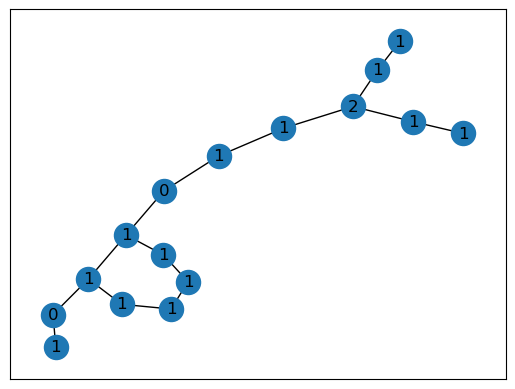

In [134]:
# Display first molecule with nodes labels.
nx.draw_networkx(training_data[0], labels=get_all_atom_types(training_data[0]))

## 3. Some statistics about the training set.

In this section, we conduct a short statistical analysis on the training set.

In [135]:
# Count number of atome (i.e. nodes) labels across training set.
atom_dict = {}

# Create a list of the length of all training molecules.
molecule_length = []

for i in range(len(training_data)) :
    
    mol = training_data[i]
    molecule_length.append(len(mol.nodes))

    for atom in mol.nodes :
        atom_type = mol.nodes[atom]['labels'][0]
        atom_dict[atom_type] = atom_dict.get(atom_type, 0) + 1

### 3.1 Distribution of molecule lengths.

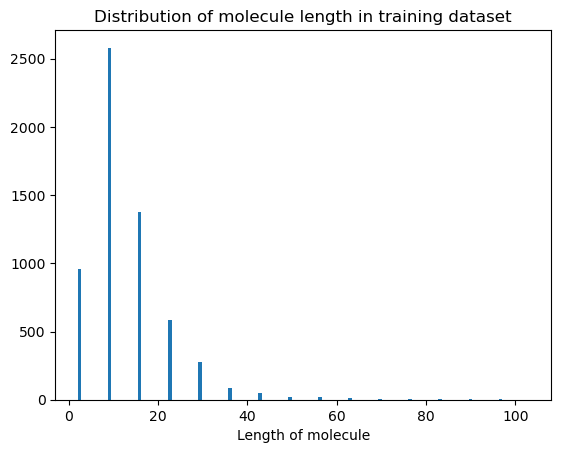

In [136]:
plt.hist(molecule_length, width=0.8, bins=15, align='mid')
plt.title('Distribution of molecule length in training dataset')
plt.xlabel('Length of molecule')
plt.show()

In [137]:
# Simple stat about molecule lengths in training set.
print(f'Average length : {np.mean(molecule_length)}')
print(f'Median length : {np.median(molecule_length)}')

Average length : 16.140333333333334
Median length : 14.0


### 3.2 Distribution of atom labels.

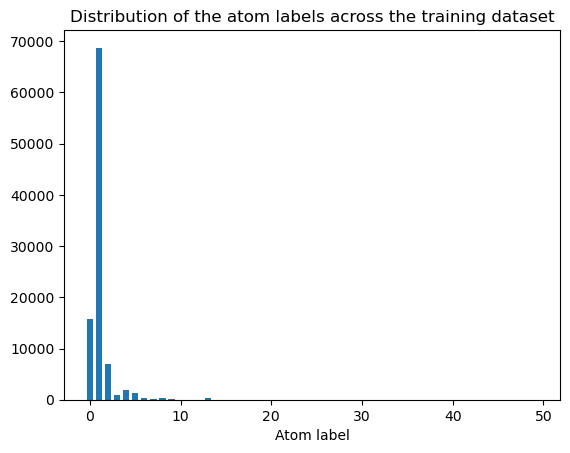

In [138]:
plt.bar(atom_dict.keys(), atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom labels across the training dataset')
plt.xlabel('Atom label')
plt.show()

We clearly observe that most atoms have the label 0, 1 or 2.

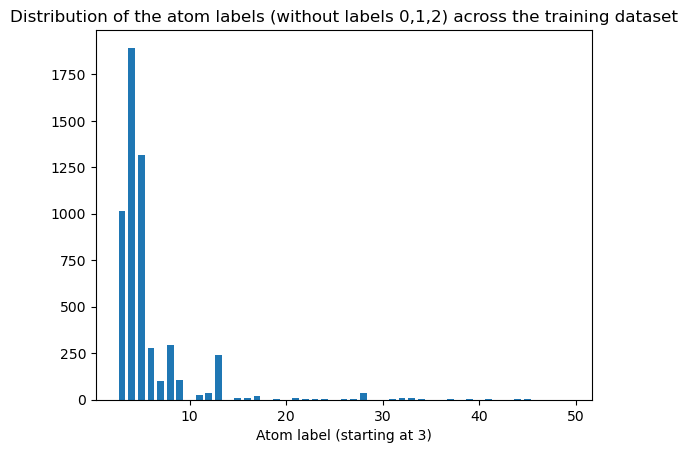

In [139]:
tail_atom_dict = atom_dict
del tail_atom_dict[0]
del tail_atom_dict[1]
del tail_atom_dict[2]
plt.bar(tail_atom_dict.keys(), tail_atom_dict.values(), width= 0.7, align='center')
plt.title('Distribution of the atom labels (without labels 0,1,2) across the training dataset')
plt.xlabel('Atom label (starting at 3)')
plt.show()

### 3.3 Distribution of edge labels.

In [140]:
edges_dict = {}

for i in range(len(training_data)) :
    
    mol = training_data[i]
    mol_length = len(mol.nodes)

    edge_list = [(i,j) for i in range(mol_length) for j in range(i+1, mol_length)]

    number_error = 0

    for edge in edge_list :
            try :
                edge_type = mol.edges[edge[0],edge[1]]['labels'][0]
                edges_dict[edge_type] = edges_dict.get(edge_type, 0) + 1
            except KeyError as e :
                number_error += 1

print(edges_dict)
print(number_error)

{2: 28308, 0: 60228, 1: 8812, 3: 238}
77


In [141]:
print(f'In the training set, {100*number_error/(sum(edges_dict.values())+number_error):.3f}% of atom bonds do not exist')

In the training set, 0.079% of atom bonds do not exist


We observe that most edges are of label 0. Given the structure of molecules, this label 0 probably means 'no bonding'. We also observe that the training set contains very few non-defined bonds between atoms.

### 3.4 Class imbalance

In [142]:
print(f"In the training set, {np.sum(training_labels)}/{len(training_labels)} = {np.sum(training_labels)*100/len(training_labels)}% of the graphs are positive.")

In the training set, 555/6000 = 9.25% of the graphs are positive.


This class imbalance must be taken into account when designing our training algorithms.

## 4. Cleaning dataset

Some molecule have strange structure, as displayed in the figure below.

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13} {14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


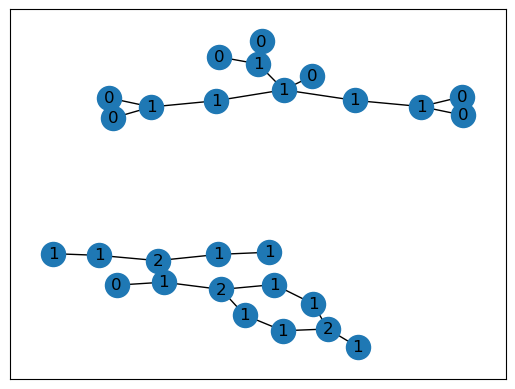

In [143]:
mol_id = 10
print(*nx.connected_components(training_data[mol_id]))
nx.draw_networkx(training_data[mol_id], labels=get_all_atom_types(training_data[mol_id]))

In this case, we observe two fully connected graphs disconnected from each other.

By using the `nx.connected_components` function from networkx library, we can create the list of all molecules having a not standard structure (i.e. having disconnected components.)

In [144]:
unconnected_graphs = 0
training_unconnected_ids = []
for mol in range(len(training_data)) :
    if len(list(nx.connected_components(training_data[mol]))) > 1 :
        unconnected_graphs += 1
        training_unconnected_ids.append(mol)

print(f'{unconnected_graphs}/{len(training_data)} unconnected graphs inside training set.')

975/6000 unconnected graphs inside training set.


In [145]:
test_unconnected_graphs = 0
test_unconnected_ids = []
for mol in range(len(test_data)) :
    if len(list(nx.connected_components(test_data[mol]))) > 1 :
        test_unconnected_graphs += 1
        test_unconnected_ids.append(mol)

print(f'{test_unconnected_graphs}/{len(test_data)} unconnected graphs inside test set.')
# print(unconnected_ids)

498/2000 unconnected graphs inside test set.


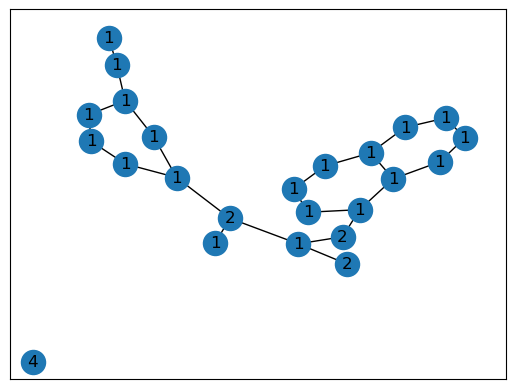

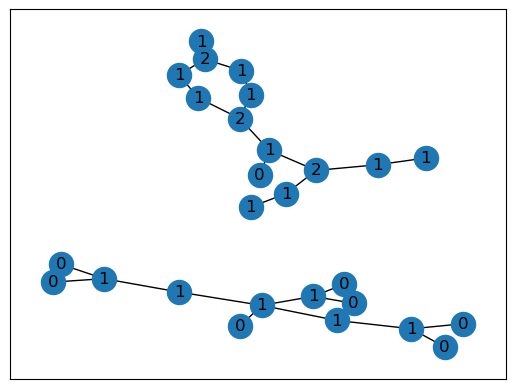

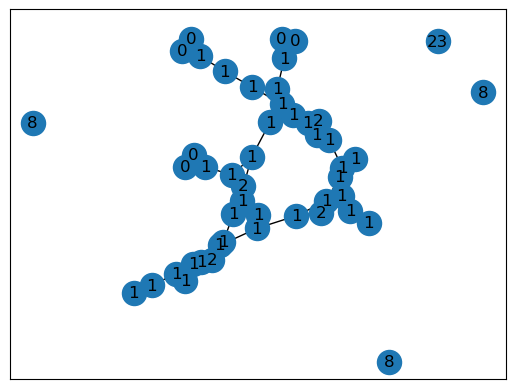

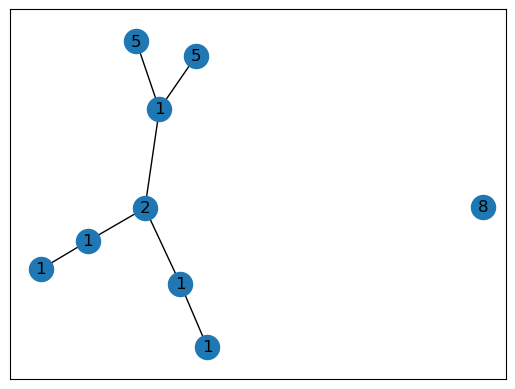

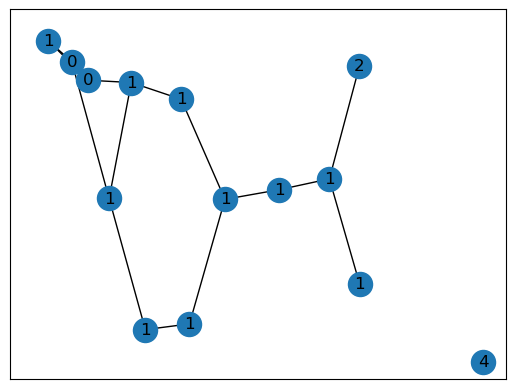

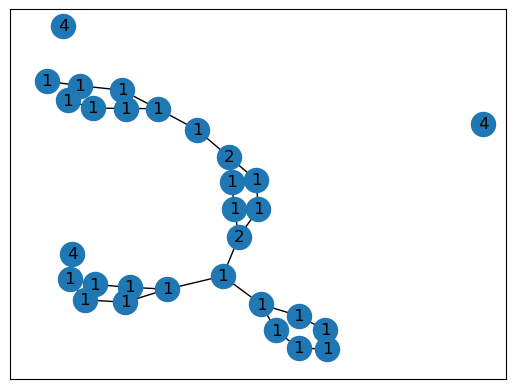

In [146]:
# Displaying some of the unconnected graphs from training set.
for k in training_unconnected_ids[:6] :
    plt.figure(k)
    nx.draw_networkx(training_data[k], labels=get_all_atom_types(training_data[k]))
    
plt.show()

We see that some disconnected molecules have isolated atoms not connected to any other atom.

We will use this knowledge to create a dataset cleaning function. See `utils.py` to get the source code of the cleaning function.

In [149]:
# Cleaning dataset.
cleaned_training_set, _ = clean_dataset(training_data, training_labels)

In [150]:
cleaned_unconnected_graphs = 0
cleaned_unconnected_ids = []
for mol in range(len(cleaned_training_set)) :
    if len(list(nx.connected_components(cleaned_training_set[mol]))) > 1 :
        cleaned_unconnected_graphs += 1
        cleaned_unconnected_ids.append(mol)

print(f'{cleaned_unconnected_graphs}/{len(cleaned_training_set)} unconnected graphs inside cleaned training set.')

0/5774 unconnected graphs inside cleaned training set.
